In [2]:
# preamble

# set up environments base -> ATOMIC_GOES
# IJulia and Revise must be installed in the Julia base @version package environment.
# Sometimes perhaps an vscode extension
using Revise # does using Revise first allow for revising code in ATOMIC_GOES???
using Pkg
# Pkg.activate(joinpath(homedir(), "Projects/ATOMIC/ATOMIC_GOES/julia/ATOMIC_GOES"))
cd("/Users/deszoeks/Projects/ATOMIC/trade-cu-model/src/julia")
Pkg.activate(".")

using Printf
using Dates
using NCDatasets
using JLD2

using Statistics
using Interpolations
using LinearAlgebra

# using PyPlot -> not thread safe in IJulia with Julia 1.12.4+
using PythonPlot

using VaporSat # dev ../../deps/VaporSat

  Activating project at `~/Projects/ATOMIC/trade-cu-model/src/julia`


In [3]:
# utility functions; extend matplotlib

if @isdefined(PythonPlot)
    using PythonCall
    "Recast julia Arrays with missing as python masked arrays."
    function PythonCall.Py(a::Array{Union{T,Missing},N}) where {T,N}
        np = PythonCall.pyimport("numpy")
        np.ma.masked_invalid(np.array(replace(a, missing => NaN)))
    end

    "close plots with close(\"all\")"
    close(s::String) = PythonCall.pyimport("matplotlib.pyplot").close(s)
elseif @isdefined(PyPlot)
    using PyCall
    using PyCall: PyObject
    # allow for plotting with missing values
    function PyCall.PyObject(a::Array{Union{T,Missing},N}) where {T,N}
        numpy_ma = PyCall.pyimport("numpy").ma
        pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
    end
end

"convert arrays with missings to masked python float64 arrays"
# msk(y) = ma.masked_invalid(np.array(replace(y, missing => NaN), dtype="float64"))


"plotf(f, x, args...)  function plot wrapper"
plotf(f, x, args...) = plot(f.(x), x, args...)

pd = permutedims

"midpoint averager"
mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16

"missing to zero"
# m2z(x) = ismissing(x) ? 0 : x
m2z(x) = replace(x, missing=>0)

# statistics fcns
"anomaly"
anom(r, kwargs...) = r .- mean(r, kwargs...)

"runningmean(x, n=7, f=isfinite) n-point running mean points satisfying f(x)==true"
function runningmean(x, n=7, f=isfinite)
    notf2zero(x) = f(x) ? x : 0
    cs = cumsum(notf2zero.(x))
    ct = cumsum(f.(x))
    (cs[n+1:end] .- cs[1:end-n]) ./ (ct[n+1:end] .- ct[1:end-n])
end

recurse(f, x, n) = n>0 ? f(recurse(f, x, n-1)) : x
"abstractly composes f n times; recursef(f,3) = f∘f∘f = x->f(f(f(x))), without evaluating"
recursef(f,n) = reduce(∘, ntuple(_ -> f, n)) 

"declare arrays with elements of Union{Missing,T} unions"
similarmissing(s::Tuple, T::Type=Float64) = Array{Union{Missing, T}}(missing, s)
similarmissing(A::Array) = similarmissing(size(A), eltype(A))

"moving_average(A, m) m-point moving average of A"
function moving_average(A::AbstractArray, m::Int, cond=x->true)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = m÷2 * oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            if cond(A[J]) # add condition, e.g. isfinite
                s += A[J]
                n += 1
            end
        end
        out[I] = s/n
    end
    return out
end

# means and helper functions

n2m(x) = isnan(x) ? missing : x
skipnan(x) = skipmissing(n2m.(x))

"replace nonmissing nonfinite by missing"
nisf2m(x) = !ismissing(x) && isfinite(x) ? x : missing
# usem e.g., mean( skipmissing(nisf2m.(x)) )

"upsample by factor n, between 2 points"
upsample1(x0, x1; n=10, a=(0:n)/n) = x0*(1-a) + x1*a

"upsample X by factor n, between points of vector x."
function upsample(x; n=10, a=(0:n)/n)
    X = zeros((length(x)-1)*n + 1)
    for i in eachindex( x[1:end-1] )
        X[n*(i-1)+1 .+ (0:n)] .= x[i]*(1 .- a) + x[i+1]*a
    end
    X
end

"\\xi(x) wrapper for upsampling linearly in log space"
ξ(x) = exp.(upsample(log.(x))) # 

ξ

In [4]:
# functions for thermodynamics

# using .VaporSat -> dev ../../deps/VaporSat

# VaporSat exports dqsdT, qsat
# here we overload some unexported methods in VaporSat

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K


# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)
LvK(T) = Lv(T-273.15)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

# use method from VaporSat qsat(p[Pa], T[C])
# note order of arguments and units
# "qsat(T[C], p[hPa])"
# qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.

# adiabatic lapse rate
lapse_ad = gravity/Cp

"moist adiabatic lapse rate p[Pa], T[K]"
lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(p,T-KelvinCelsius)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(p,T-KelvinCelsius)/(Rd*Cp*T*T))
# lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(T-273.0,p)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(T-273.0,p)/(Rd*Cp*T*T))

"parcel process adiabatic change in saturation vapor pressure, p[Pa], T[K]"
dqsatdz_moistad(p,T) = dqsdT(p,T-KelvinCelsius) * -lapse_moist(T,p) # negative
# Small inconsistencies between dqsdT (Bolton) 
# and lapse_moist (Rogers and Yau) methods
# are OK here.

"density temperature for liquid water loading (exact, or take default approximation)"
liqldfac(ql; rhoa_o_rhoL=0.001) = 1 - (1 - rhoa_o_rhoL) * ql
Tliqld(Tv, ql; p=1e5, rhoa=p/(Rd*Tv)) = Tv * liqldfac(ql; rhoa_o_rhoL=rhoa/1000.0)

Tliqld (generic function with 1 method)

In [5]:
# load data

# prefixer() = startswith(gethostname(), "sundog") ? "/mnt/c" : "/"
# datapath = joinpath(prefixer(), "Users/deszoeks/Data/ATOMIC/radiosonde/level2")
datapath = "../../data/flux"

# PSL flux data file
# EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc
psl = NCDataset(joinpath(datapath, "EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc"))
# mean(skipmissing(psl["hl_bulk"][:]))
# mean(skipmissing(psl["prate"][:])) # 0.031 mm/h

# E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
# P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # W/m^2

# sondes data file
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

ds[:alt][:] # 3100, 10-m vert resolution
ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# p(sounding, alt) ;
# lat(sounding, alt) ;
# lon(sounding, alt) ;
# dz(sounding, alt) ;
# ta(sounding, alt) ;
# dp(sounding, alt) ;
# wspd(sounding, alt) ;
# u(sounding, alt) ;
# v(sounding, alt) ;
# mr(sounding, alt) ;
# theta(sounding, alt) ;
# q(sounding, alt) ;
# wdir(sounding, alt) ;
# rh(sounding, alt) ;
# N_ptu(sounding, alt) ;
# N_gps(sounding, alt) ;

# ncdump -h EUREC4A_Atalante_Vaisala-RS_L2_v2.2.0.nc | grep -o -e "float \(\w*\)" | awk '{print $2}'
floatvars = split("p lat lon dz ta dp wspd u v mr theta q wdir rh N_ptu N_gps")

dsa = NCDataset("../../data/goes16_binned_low4km_20200115_20200219.nc")
rfv_nrm = mean(dsa[:rfv_nrm][:,:], dims=2)
rfv_acc = mean(dsa[:rfv_acc][:,:], dims=2)
cth_bin = dsa[:cth_bin][:]
size(rfv_nrm), size(cth_bin)

((351, 1), (351,))

In [6]:
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

# ds[:alt][:] # 3100, 10-m vert resolution
# ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# size()

Dataset: /Users/deszoeks/Data/ATOMIC/radiosonde/level2/EUREC4A_RonBrown_Vaisala-RS_L2_v3.0.0.nc
Group: /

Dimensions
   sounding = 327
   alt = 3100
   nv = 2

Variables
  alt   (3100)
    Datatype:    Int16 (Int16)
    Dimensions:  alt
    Attributes:
     long_name            = geopotential height
     standard_name        = geopotential_height
     units                = m
     axis                 = Z
     positive             = up
     bounds               = alt_bnds

  flight_time   (3100 × 327)
    Datatype:    Union{Missing, DateTime} (Float64)
    Dimensions:  alt × sounding
    Attributes:
     _FillValue           = 9.96921e36
     long_name            = time at pressure level
     standard_name        = time
     ancillary_variables  = N_ptu m_ptu
     cell_methods         = alt: mean (interval: 10 m comment: m_ptu)
     coordinates          = lon lat alt launch_time
     units                = seconds since 2020-01-01
     calendar             = proleptic_gregorian

  p   

In [7]:
"average all sounding times. preserve levels"
tmean(var, ds=ds) = [mean(skipmissing(ds[var][i,:])) for i in axes(ds[var][:,:],1)]

# get mean sounding data
z = ds[:alt][:]
tam = tmean(:ta) # K
thm = tmean(:theta)
qm  = tmean(:q)
pm  = tmean(:p) # Pa
qs  = qsat.(pm, tam.-KelvinCelsius) # kg/kg

tvm  = tam .* (1 .+ 0.608*qm) # virtual temperature, K
thvm = thm .* (1 .+ 0.608*qm) # virtual temperature, K
#tdm = tvm # liqldfac(ql) # density temperature, K; no liquid water in env

3100-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 300.2618746926288
 300.24341779610216
 300.23035770123914
 300.2216013036639
 300.2195188771893
 300.21850724665256
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [8]:
# large scale profile for cloud & flux model

# vertical grid
z = ds[:alt][:]
ii = findall(isfinite.(qm))

Nsq = gravity * diff(log.(thvm))./diff(z)

zi =   4.0e3    # m
ztop = 4.0e3
# cloud base initial condition
zcb = 600
icb = findfirst(z .>= zcb) # cloud base index
qcb = qs[icb] # 0.0157
#Δq = qs .- qm # depends on environment only # different in paper text!

# derivatives
dz = 10.0 # z[2] - z[1]
dqdz  = diff(tmean(:q)) / dz
dqsdz = diff( qs      ) / dz
qm = tmean(:q)
z = ds[:alt][:]
ii = findall(isfinite.(qm))

# total large scale drying, add advection term in lower atm
divg = 1.5e-6 # 1/s

"large scale subsidence vertical velocity (m/s)"
subsidence(z; divg=divg, zi=zi) = -min(z,zi) * divg # <0
wdqdz = subsidence.(z[1:end-1]) .* dqdz
# ^ negate on rhs

# large scale source
S_ls = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) 

# vertical means over the cloud layer
Tmean = mean(skipnan(tmean(:ta)[ds[:alt].<=ztop])) # 286.6K = mean Cu layer temperature
pmean = mean(skipnan(tmean(:p)[ds[:alt].<=ztop]))
L = Lv(Tmean)
rhoL = pmean/(Rd*Tmean) * L

#=
E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # -> 25 W/m^2
=#

2.426927036481407e6

In [9]:
# plot buoyancy frequency
close("all")
subplot(2,2,1)
plot((x->x>0 ? 2*pi/sqrt(x)/60 : NaN).(Nsq), (z[1:end-1].+5.0)./1e3)
ylim([0, 5])
xlim([0, 40])
ylabel("z (km)")
xlabel("period (min)")

subplot(2,2,2)
plot((x->x>0 ? sqrt(x) : NaN).(Nsq), (z[1:end-1].+5.0)./1e3)
ylim([0, 5])
xlim([0, 0.02])
xlabel("buoyancy frequency (s\$^{-1}\$)")
"slow omega<N, periods longer than 10 min, propagate"

"slow omega<N, periods longer than 10 min, propagate"

In [10]:
# compute total all-sky flux G with cloud base BC

# cloud base vapor flux initial condition
Ecb = 180 # E0 - 35; just the cloud vapor flux
Gcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # _total_ flux F at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
G = similarmissing(qm)
# A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) # as above
G[icb:end] = Gcb .+ vcat(0, cumsum( S_ls[icb:end] ) * dz)

# icb = findfirst(.!ismissing.(F))
itop=lastindex(G)-1 

3099

In [11]:
# plot G as a function of height
close("all")
subplot(1,2,1)
plot(S_ls, z[1:end-1]/1e3)
title("large-scale source S\$_\\text{LS}\$ (kg/kg /s)")
ylim([0, 8])

subplot(1,2,2)
plot(G, z/1e3)
plot([0, 0], [0, 8], "k-", linewidth=0.5)
title("all-sky flux G\$_\\text{LS}\$ (kg/kg m/s)")
ylim([0, 8])
xlim([-0.5e-5, 7e-5])
# gcf()
"The surface moisture flux balances the large scale source integrated from CB to ~8 km."


"The surface moisture flux balances the large scale source integrated from CB to ~8 km."

Is the mean precipitation (25 W m^-2) supposed to happen elsewhere, 
downstream of the trade cumulus regime?

Precipitation (mean 25 W m^-2) is intermittently scattered into the trade cumulus regime by moist tongues and synoptic convergence. 
We think of these convective enhancements as "downstream" along column quasi-Lagrangians because of their greater column moisture.

## cloud ensemble, heights and area fractions

### Method 1, Horizontally uniform cloud eddy flux:
We distribute the all-sky mean flux G to the all-cloud mean 
$F=a_{cld}^{-1} G$, and then *evenly* to each cloud. If each cloud at level z has the same mean flux F_i (z)=F(z), then the all sky flux is
$$
G(z)=∑F_i (z)[a_i H(h_i-z)]=F(z)∑[a_i H(h_i-z)]=a_{cld}(z)F_1(z)
$$
with total cloud fraction at height z of 
$a_{cld}(z)=∑[a_i H(h_i-z)]$ and Heaviside function $H(x)={1,x≥0;0,x<0}$. As the flux decreases with height, there are fewer clouds to carry the mean flux.

$F_i = F_1(z)$ does not depend on $i$.

Only count clouds with tops below height $z$, so $a_{cld}(z)$ decreases with height. 

So
$$
a_{cld}(z_k) = \sum_{i=1,k}a_i
$$

### Method 2, Vertically uniform cloud eddy flux: 
The all-sky mean flux profile $G(z)$ has a flux difference at each height $h_i$ of $(ΔG)_i=-[G(h_{i+1})-G(h_i)]$. This flux difference is assumed to be carried by the clouds with area fraction $a_i$ and height $h_i$, so the mean flux in cloud category $i$ is vertically uniform, 
$F_i=a_i^{-1} (ΔG)_i$.

This is the flux for each cloud category $i$. It is uniform from cloud base to $h_i$ and goes to zero above $h_i$.

### Method 1, Horizontally uniform cloud eddy flux

In [12]:
# calculate F1 - not used

# check cloud fraction
sum(rfv_nrm) ≈ maximum(rfv_acc) # true
# plot(rfv_acc, dsa[:cth_bin]) # decreases with height

# F1 = pd(G) ./ rfv_acc # dimension (category_i, z) ---WRONG---
# line up bins
offset = findfirst(x->x≈dsa[:cth_bin][1]*1e3, z) - 1 # 50
#test offset
z[offset] == dsa[:cth_bin][1]*1e3 # true; cth_bin starts at z=500


"""
calcF1(G, rfv_acc)
Horizontally uniform cloud eddy flux calcF1
We distribute the all-sky mean flux G to the all-cloud mean 
``F_1=a_{cld}^{-1} G``, and then *evenly* to each cloud. If each cloud at level z has the same mean flux F_i (z)=F(z), then the all sky flux is
```math
G(z)=∑F_i (z)[a_i H(h_i-z)]=F(z)∑[a_i H(h_i-z)]=a_{cld}(z)F_1(z)
```
with total cloud fraction at height z of 
``a_{cld}(z)=∑[a_i H(h_i-z)]`` 
and Heaviside function 
``H(x)={1,x≥0;0,x<0}``. 
As the flux decreases with height, there are fewer clouds to carry the mean flux.

``F_i = F_1(z)`` does not depend on ``i``.

Only count clouds with tops below height ``z``, so ``a_{cld}(z)`` 
decreases with height. 
So
```math
a_{cld}(z_k) = ∑_{i=1,k}a_i.
```
"""
function calcF1(G, rfv_acc)
    alignGi(G, rfv_acc) = G[offset.+eachindex(rfv_acc)]
    return alignGi(G, rfv_acc) ./ rfv_acc # dimension (z), does not depend on category_i
end

F1 = calcF1(G, rfv_acc)
F1mod = calcF1(G, rfv_acc.+0.02)

# calculate F2

# ΔG = -diff(G) # z grid
# prototype
# F2 = -diff(G)[offset.+eachindex(rfv_nrm)] ./ rfv_nrm[:] # dimension category_i
# rfv_acc[end] == 0.0

calcF2_(G, acc; sk=1) = diff(G[1:sk:end]) ./ diff(acc[1:sk:end]) # dimension category_i, inputs asligned!

"""
calcF2(G, rfv_acc)
Vertically uniform cloud eddy flux 
The all-sky mean flux profile ``G(z)`` has a flux difference 
at each height ``h_i`` of ``(ΔG)_i=-[G(h_{i+1})-G(h_i)]``. 
This flux difference is assumed to be carried by the clouds with 
area fraction ``a_i`` and height 
``h_i``, so the mean flux in cloud category ``i`` is vertically uniform, 
``F_i=a_i^{-1} (ΔG)_i``.

This is the flux for each cloud category ``i``. It is uniform from cloud base to ``h_i`` and goes to zero above ``h_i``.
"""
function calcF2(G, rfv_acc; sk)
    align2i(G) = G[offset.+eachindex(rfv_acc)] # dimension category_
    return calcF2_(align2i(G), rfv_acc; sk=sk) # inputs not aligned
end

F2 = calcF2(G, rfv_acc; sk=1)

# coarsen bin size to 100 m
F2c = calcF2(G, rfv_acc; sk=10)
# mean not weighted by area
# F2m = mean(skipmissing(nisf2m.(F2)))
# mean weighted by area
F2m = sum( skipmissing(nisf2m.(F2) .* rfv_nrm[1:end-1]) ) / sum( rfv_nrm )
"The mean flux over all cloud categories i is $(round(F2m*1e3, digits=2)) g/kg m/s = $(round(F2m*rhoL, digits=0)) W/m²"

"The mean flux over all cloud categories i is 0.68 g/kg m/s = 1658.0 W/m²"

In [13]:
# plot F1
close("all")
fig, ax = subplots(1,1)
plot(rfv_acc/1e2, dsa[:cth_bin], label="cloud fraction")
# plot(F1, dsa[:cth_bin], label="cloud-sky flux")
plot(F1mod, dsa[:cth_bin], label="cloud-sky flux")
ylabel("height z")
# xlim([-0.0005, 0.35]); ylim([0, 4.01])
title("cloud-mean flux \$F_1(z)\$ (kg/kg m s\$^{-1}\$)")
legend(frameon=false)
# gcf()


Python: <matplotlib.legend.Legend object at 0x350060050>

Almost all the flux is carried by the tallest clouds.

In [14]:
# plot F2

close("all")
figure()
plot(vec(dsa[:cth_bin][eachindex(F2)]), 1e3*F2, label="category i flux (10 m)")
plot(vec(dsa[:cth_bin][5:10:end-1]), 1e3*F2c, label="coarsened flux (100 m)")
plot([0.6, 4], [1e3, 1e3].*F2m, label="mean flux")
plot(vec(dsa[:cth_bin][eachindex(F2)]), 1e3*rfv_nrm[eachindex(F2)], label="cloud fraction 10\$^{-3}\$")
title("large-scale flux \$F_{i}\$")
legend(frameon=false)
xlabel("category h\$_i\$ (km)")
ylabel("\$F\$ (g/kg m/s)")
ylim([0, 1.75])
xlim([4, 0.6])
# gcf()
"""
Vertically uniform cloud-sky flux \$F_i\$ for each cloud category i.
Mean over all categories is $(round(F2m*1e3, digits=2)) g/kg m/s = $(round(F2m*rhoL, digits=0)) W/m²
"""

"Vertically uniform cloud-sky flux \$F_i\$ for each cloud category i.\nMean over all categories is 0.68 g/kg m/s = 1658.0 W/m²\n"

## cloud model

In [15]:
# cloud model - updraft total water and cloud water functions
# Updraft q_total, ql do not depend on F or Fcld.
# Below, mass flux W depends on q_total and Fcld.

"qtilde=(1-x)*qm .+ x*qs intermediate environmental moisture function"
function q_tilde(qm, qs, x)
    (1-x)*qm .+ x*qs
end

"updraft q_total function"
function q_total(aedz, x, qs, qm; i0, qt0, stopattop=false)
    qtilde=(1-x)*qm .+ x*qs
    qt = copy(qtilde)
    qt[1:i0] .= qt0 # cloud base initial condition
    # in cloud
    for i in i0:length(qt)-1
        if qt[i] > qs[i] # in cloud
            a = aedz
            Q = 0.5*(qtilde[i]+qtilde[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif !stopattop   # above cloud
            a = (1-x)*aedz  # no precipitation sink
            Q = 0.5*(qm[i]+qm[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif stopattop  # above cloud, stop at cloud top
            qt[i+1] = -999
        end
    end
    return qt
end

# cloud flux Fcld functions
# ql needs to be calculate by the cloud functions already
"""
Iterates up cloud flux modifying Fcld with precipitation efficiency x and total flux F.
Must initialize cloud base Fcld[icb] first!
"""
function cloudflux!(Fcld, x, ae, F, ql, qt, qm, icb=icb, itop=min(lastindex(F),findfirst(.!ismissing.(F) .&& F.<0)+20))
    Δq = qt .- qm
    c = @. -x*ae * ql / Δq * dz/2 # Q*dz stepping quantity # /2 added 2025 Aug 16
    # step Fcld through the trade Cu layer
    for i in icb:itop
        Fcld[i+1] = (F[i+1]-F[i] + Fcld[i]*(1+c[i])) / (1-c[i+1])                
    end
end

"integrate precipitation down to cloud base by stepping"
function precipflux_down_sfc(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = 0.0 # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        # P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
        P = ( (1+c[i+1])*P + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    return P # at cloud base
end

"precipitation profile integrated downward from cloud top"
function precipflux_down!(P, x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    # P = zeros(size(F)) # at cloud top istart
    P[istart] = 0.0
    for i in (istart-1):-1:icb
        # update P by 1 step
        P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    P[1:icb-1] .= NaN
end

"precipitation profile integrated downward from cloud top"
function precipflux_down(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    P = zeros(size(F)) # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    P[1:icb-1] .= NaN # below cloud base
    return P # precip flux vector
end

precipflux_down

In [16]:
# align F2 to cloud model z grid
F2z = Array{Union{Missing, Float64}}(missing, size(qm))
F2z[offset.+eachindex(F2)] .= F2[:] 
# needs to be masked with 0 above cloud top
# plot(F2z)

350-element view(::Vector{Union{Missing, Float64}}, 51:400) with eltype Union{Missing, Float64}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 ⋮
 0.0018855221077295845
 0.0016935773596736799
 0.0011938169837634308
 0.0010599436804751027
 0.0017626744700612773
 0.002315021870752285
 0.0022910427884339497
 0.0027769756353865837
 0.00349117924024463

In [17]:
# iterate cloud model for F2z_i

#cloud base and cloud top indices
ist = findfirst(z .>= 2000)
ien = findfirst(z .<= 5000)

"terminate the cloud at ql=0"
findcloudtop(ql) = findfirst(ql .== 0 .&& z .> zcb )

findshallowc(ql) = min(findcloudtop(ql) )

"terminate the cloud either at ql=0 or at the elevated minimum ql in the trade inversion"
function findcloudtop(ql, ist,ien)
    itop = findfirst(ql .== 0 .&& z .> zcb )
    if isnothing(itop) # choose the minimum 
        itop = argmin(ql[ist:ien]) + ist - 1
    end
    itop
end

# detect deep convective clouds
"max ql of low clouds, below 3600 m"
low_argmax(ql,z) = argmax(skipmissing(replace(ql, NaN=>missing) .* (z.<3600)))

"Find the minimum in cloud above the trade inversion. Shallow Cu cloud top should be below this."
function high_argmin(ql,z) 
    lax = low_argmax(ql,z)
    lst = findlast( z .< 3600 )
    argmin(skipmissing(replace(ql[lax:lst], NaN=>missing))) + lax - 1
end
"return true for deep clouds having no ql <= 0 between max ql of low cloud and 4 km"
deep_cloud(ql,z) = minimum(ql[low_argmax(ql,z):findfirst(z.>=4000)]) > 0.0

deep_cloud

In [18]:
# compute a measure of cloud fraction da/dsink = da/dh * dh/dsink

"return the first unique indices of a"
uniqueind(a) = unique(i -> a[i], eachindex(a))

# not used?
function hmid_0_4km(h)
    nh = findfirst(x->x>=4000, h)
    hm = (h[1:nh-1] .+ h[2:nh]) / 2
end

function sortunique(ztop)
    ui_ = uniqueind(ztop[:])
    oi = sortperm(ztop[ui_])
    ui = ui_[oi]
end

"""
dadsinkrate(ztop, tot_sink, rfv_nrm, dh=10.0)
Compute cloud fraction density per unit sink rate 
da/dsinkrate = da/dh * dh/dsinkrate.
Interpolates satellite coordinate to model sinkrate coordiante.
"""
function dadsinkrate(ztop, tot_sink, rfv_nrm, dh=10.0)
    # condition vertical coordinate
    ui = sortunique(ztop)
    h = ztop[ui] # sorted ascending
    hm_ = (h[1:end-1] .+ h[2:end]) / 2
    ii = hm_ .<= 4000
    hm = hm_[ii]

    dh_dsink = diff(h) ./ diff(tot_sink[ui])

    # satellite coordinate --> da/dh
    da_dh = rfv_nrm[:] / dh
    # interpolate satellite a(h) to unique h_sink coordinate
    da_dh_to_sink = linear_interpolation((cth_bin*1e3,), da_dh).(hm) 
    da_dsink = da_dh_to_sink .* -dh_dsink[ii]
end

# usage later:
# da_dsink = dadsinkrate(ztop, tot_sink, rfv_nrm)

dadsinkrate

In [19]:
# refine cloud top for x=0.53

x = 0.53
# nx = 500
# pcp_effic = range(0, 1, length=nx) #0:0.005:0.9         # precipitation efficiency
nz = length(z)
ns = 600
# tot_sink = (1 .+tanh.(range(-8*pi, 0, length=ns))) .* (5e-3 - 1e-4) .+ 1e-4
# tot_sink = range(6.1716e-4, 5.8e-3, length=ns) # min tuned for x=0.53 to get the highest possible cloud top
tot_sink = range(6.3523e-4, 5.7e-3, length=ns) # min tuned for x=0.53 to get the highest possible cloud top

"Compute clouds and fluxes for a single precipitation efficiency x and a range of sink rates tot_sink."
function cloudflux_1x(tot_sink=tot_sink; x=x)
    qtc  = Array{ Union{Missing, Float64},2}(missing, nz, ns)
    Fcld = Array{ Union{Missing, Float64},2}(missing, nz, ns)
    Fp   = Array{ Union{Missing, Float64},2}(missing, nz, ns)
    # Pcb  = Matrix{Union{Missing, Float64}}(missing, ns)
    ztop = Vector{Union{Missing, Float64}}(missing, ns)
    # zmin = Matrix{Union{Missing, Float64}}(missing, ns)
    ff   = Vector{Union{Missing, Float64}}(missing, nz)

    # ix = findfirst( pcp_effic .>= x)
    qtilde = q_tilde(qm, qs, x) # depends on precipitation efficiency
    for ia in eachindex(tot_sink)
        ae = tot_sink[ia]
        # compute clouds
        qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
        ql = max.(0, qt.-qs)
        itop = findcloudtop(ql)
        ztop[ia] = z[itop] # ztop can be up to 20 km
        if !isnothing(itop) && !deep_cloud(ql,z)
            qtc[:,ia] .= qt
            fill!(ff, F2z[itop]) # use uniform flux for the experiment's cloud top height
            Fp[:,ia] .= -precipflux_down( x, ae, ff, ql, qt, qm, istart=itop, icb=icb )
            # Pcb[ia] = -Fp[icb,ia]
            # cloud updraft flux
            Fcld[:,ia] .= -Fp[:,ia] .+ F2z[itop]
            # cloud        = -precip         eddy
        end
    end
    ztop, Fcld, Fp, qtc
end

zt53, Fcld53, Fp53, qtc53 = cloudflux_1x(tot_sink; x=0.53)
Pcb53 = -Fp53[icb,:] # cloud base precip
# any(x->!ismissing(x), zt) # true!
ii = findall(x-> zcb+50<x<4000, zt53)
plot(tot_sink[ii], zt53[ii], marker=".", linestyle="none")
ylim([0, 3600])

"""
Highest cloud top is $(round(zt53[ii][1]/1e3, digits=2)) km \
for x=$(x) at sink rate $(round(tot_sink[ii[1]]*1e3, sigdigits=4)) km^-1.
"""

"Highest cloud top is 3.54 km for x=0.53 at sink rate 0.6352 km^-1.\n"

In [20]:
# compute w for a single x and range of sink rates

function updraft_w_dq(Fcld, qtc, qm, ztop)
    dq = qtc .- qm
    w = convert(Matrix{Union{Missing,Float64}}, Fcld ./ dq)
    for i in axes(w,2) # blank out w above clouds
        ii = z .> ztop[i]
        w[ii,i] .= missing
    end
    return w, dq
end

w53, dq53 = updraft_w_dq(Fcld53, qtc53, qm, zt53)

# compute da/dsink for x=0.53
da_dsink = dadsinkrate(zt53, tot_sink, rfv_nrm)

192-element Vector{Float64}:
   4.358807651875809
   4.981120519427756
   3.862413107040532
   3.4850380191476096
   3.8846769739051146
   2.927100049601566
   5.029128192856512
   4.410704464344866
   3.561168630843089
   2.9794632427256196
   ⋮
  59.64090995595093
  55.823776053379916
  54.68016498486919
  85.69380419577786
  80.7535516986551
  81.57861439775868
 109.9443680491688
  86.8436027925788
 226.61919261129052

In [23]:
"Plot cloud profiles for a single precipitation efficiency x and a range of sink rates tot_sink."
function plot_qv_qc_w(tot_sink, z, da_dsink, ztop, qtc, Fcld, w, qm, qs; x=0.53, ntp=500)
    if @isdefined(PythonPlot) PyPlot=PythonPlot end

    # vertical coordinate
    ui = sortunique(ztop)
    h = ztop[ui] # sorted ascending
    hm_ = (h[1:end-1] .+ h[2:end]) / 2
    ii = hm_ .<= 4000
    hm = hm_[ii]

    dq = qtc .- qm
    
    figure(figsize=(9, 11))

    subplot(5,2,1)
    contourf(tot_sink*1e3, z[1:ntp]/1e3, qtc[1:ntp,:]*1e3, cmap=ColorMap("RdYlBu_r"))
    cb = colorbar()
    plot(tot_sink*1e3, ztop[:]/1e3, "k", label="cloud top height")
    # plot(tot_sink[ui][1:end-1][ii]*1e3, 0.02*da_dsink, "w", linewidth=0.5, label="da/d(sink)")
    ylim([0, 4])
    title("total cloud specific humidity (g kg\$^{-1}\$)")
    text(0.05, 3.4, "a")

    subplot(5,2,3)
    contourf(tot_sink*1e3, z[1:ntp]/1e3, dq[1:ntp,:]*1e3, levels=0:0.5:10, vmin=0, vmax=10, cmap=ColorMap("RdYlBu_r"))
    cb = colorbar()
    contour(tot_sink*1e3, z[1:ntp]/1e3, max.(0,qtc[1:ntp,:].-qs[1:ntp])*1e3, levels=0:0.2:3, vmin=0, vmax=3, colors="k", linewidths=0.5)
    plot(tot_sink*1e3, ztop[:]/1e3, "w")
    ylim([0, 4])
    title("updraft\$-\$environment humidity,\ncloud water (g kg\$^{-1}\$)")
    # xlabel("sink rate (km\$^{-1}\$)")
    ylabel("z (km)")
    text(0.05, 3.4, "b")

    subplot(5,2,5)
    levs = 0:0.05:0.5
    norm = PyPlot.matplotlib.colors.BoundaryNorm(levs, 256)
    pcolormesh(tot_sink*1e3, z[1:ntp]/1e3, w[1:ntp,:], norm=norm, cmap=ColorMap("RdYlBu_r"))
    colorbar()
    plot(tot_sink*1e3, ztop[:]/1e3, "k", label="cloud top height")
    ylim([0, 4])
    xlabel("sink rate (km\$^{-1}\$)")
    title("cloud-mean vertical velocity (m s\$^{-1}\$)")
    text(0.05, 3.4, "c")

    tight_layout()
    return gcf()
end


plot_qv_qc_w

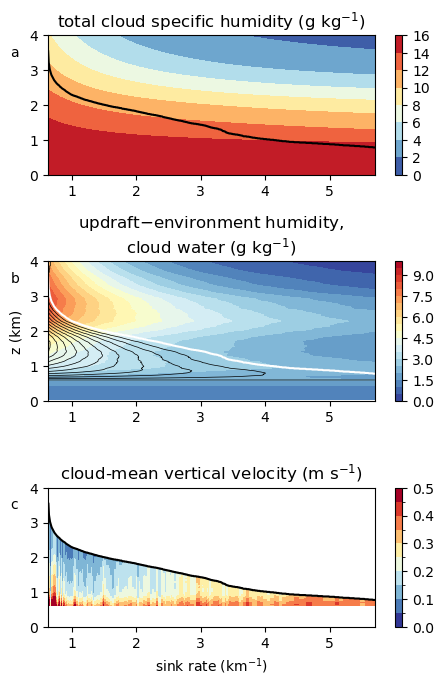

"FIG WPROF"

In [ ]:
# make the model profile ensemble plot
close("all")
fig = plot_qv_qc_w(tot_sink, z, da_dsink, zt53, qtc53, Fcld53, w53, qm, qs)
display(fig) # works in PythonPlot and PyPlot

fmt = split("png eps pdf svg")
[ savefig("wprof.$(f)") for f in fmt ]
"FIG WPROF"
# takes 50 s

In [28]:
# save data in tradeCu_clouds_flux_xp53.nc
# It takes as long to save the data as it does to generate it.
m2n(x) = ismissing(x) ? NaN : x

# save data
let do_it=false
    if do_it
        ntp = 500
        perm=(2,1)
        poot(A) = m2n.(permutedims(A)) # makes NetCDF compliant

        df = Dataset( "tradeCu_clouds_flux_xp53.nc", "a", format=:netcdf4)

        # coordinates
        df[:height][:] = z[1:ntp]
        df[:total_sink_rate][:] = tot_sink
        # dependent variables
        df[:cloud_top_height][:] = pd(zt53)

        df[:flux_cloud][:,:] = m2n.(permutedims(Fcld53[1:ntp,:], perm))
        df[:flux_eddy][:,:] = poot((Fcld53 .+ Fp53)[1:ntp,:]) # F2z[h_i]
        sync(df)
        df[:flux_precip][:,:] = poot(Fp53[1:ntp,:])
        df[:vert_vel][:,:]   = poot(w53[1:ntp,:])
        sync(df)
        df[:q_total_cloud][:,:] = poot(qtc53[1:ntp,:])

        df[:q_env][:] = m2n.(qm[1:ntp])
        df[:q_sat_env][:] = m2n.(qs[1:ntp])
        close(df)
    end
end

In [29]:
# subset w to diagnose vertical modes
let w=w53, ztop=zt53, ntp = 400
    start_ae = findfirst(any(x->!ismissing(x) && isfinite(x), w[:,:], dims=1)[:])
    start_cb = findfirst(any(x->!ismissing(x) && isfinite(x), w[:,:], dims=2)[:])
    stop_top = findlast(any(x->!ismissing(x) && isfinite(x), w[:,:], dims=2)[:])

    close("all")
    pcolormesh(tot_sink[start_ae:end]*1e3, z[start_cb:stop_top]/1e3, w[start_cb:stop_top,start_ae:end], cmap=ColorMap("RdYlBu_r"), vmax=0.5)
    colorbar()
    contour(tot_sink[start_ae:end]*1e3, z[start_cb:stop_top]/1e3, w[start_cb:stop_top,start_ae:end], levels=0.0:0.1:0.5, linewidths=0.4, colors="k")
    contour(tot_sink[start_ae:end]*1e3, z[start_cb:stop_top]/1e3, w[start_cb:stop_top,start_ae:end], levels=0.6:0.1:0.8, linewidths=0.4, colors="w")
    plot(tot_sink[start_ae:end]*1e3, ztop[start_ae:end]/1e3, "k", label="cloud top height")
    # ylim([0, 4])
    ylabel("height (km)")
    xlabel("sink rate (km\$^{-1}\$)")
    title("cloud-mean vertical velocity (m s\$^{-1}\$)")
end
"has a quasi- lower triangular structure"

"has a quasi- lower triangular structure"

In [95]:
# load cloud fraction by reflectance data from ATOMIC-GOES
# pwd()
@load "../../../ATOMIC_GOES/julia/cth_cloudfrac_byrefl.jld2" refl_bin cthbins cth_cloudfrac_byrefl cloudfrac_byrefl area_byrefl cth_cloudarea_byrefl cloudarea_byrefl cth_lowcloudfrac_byrefl lowcloudfrac_byrefl cth_lowcloudfrac2_byrefl lowcloudfrac2_byrefl # cth_cloudfrac_lt4km_byrefl cloudfrac_lt4km_byrefl

11-element Vector{Symbol}:
 :refl_bin
 :cthbins
 :cth_cloudfrac_byrefl
 :cloudfrac_byrefl
 :area_byrefl
 :cth_cloudarea_byrefl
 :cloudarea_byrefl
 :cth_lowcloudfrac_byrefl
 :lowcloudfrac_byrefl
 :cth_lowcloudfrac2_byrefl
 :lowcloudfrac2_byrefl

In [96]:
# cthbins # 617
# zt53 # 600
# size(cloudfrac_byrefl) # 21

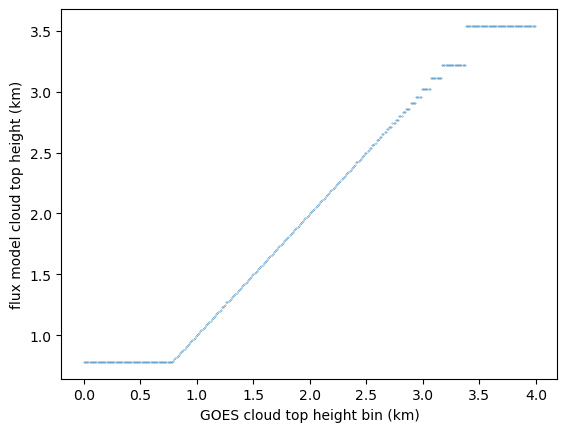

In [ ]:
# align cloud top height bins to model z grid (0.5-4 km)

"""
icloudtop, iztop = align_cloudtop_grids(ztop, cthbins)
returns indices of aligned satellite cloud top height bins cthbins 
to model cloud top heights ztop.
"""
function align_cloudtop_grids(ztop=zt53, cthbins=cthbins)
    # iterate through the cthbins

    # find nearest neighbor indices
    iz = [argmin(abs.(ztop .- b)) for b in cthbins]
    # filter out-of-range indices
    ii = findall(0 .< iz .<= length(ztop))
    return iz[ii], ii
end

# test the alignment
let ztop = zt53, ntp=400
    iz, ii = align_cloudtop_grids(ztop, cthbins[1:ntp])
    close("all")
    plot(cthbins[ii]/1e3, ztop[iz]/1e3, marker=".", markersize=0.5, linestyle="none")
    xlabel("GOES cloud top height bin (km)")
    ylabel("flux model cloud top height (km)")
    # cthbins[380], ztop[iz[380]]
    display(gcf())
end

In [98]:
# size(cthbins) # 617
# size(cth_cloudfrac_byrefl) # 21, 617
# size(Fcld53) # 3100, 600

In [ ]:
"set Fcld to missing above cloud top"
function mask_above_cloudtop(Fcld, z, zt)
    Fcldm = copy(Fcld)
    for i in axes(Fcldm,2)
        ii = z .> zt[i]
        Fcldm[ii,i] .= missing
    end
    return Fcldm
end

"""
For each reflectance bin, find the satellite cloud fraction corresponding to 
the model cloud top height.
Update the cloud fraction with the indices of the aligned bins.
"""
function ensemble_massflux_G_i!(awi, aFcldi; ztop=zt53, Fcld=Fcld53, w=w53, ai=cth_cloudfrac_byrefl, cthbins=cthbins)
    iz, ii = align_cloudtop_grids(zt53, cthbins)
    # cthbins[ii] # satellite cloud top height bins that are aligned to model z grid
    # ai = cth_cloudfrac_byrefl[:, ii] # [refl,ztop] satellite cloud fraction for the aligned bins
    # index model results with z coordinate AND ensemble dimensions
    # merge satellite and model along ensemble dimension (i, ztop, sink rate)
    for ri = axes(ai,1)
    for zi = axes(Fcld,1)
        for idx in eachindex(ii)
            i_ = ii[idx] # cloud top indices for satellite
            z_ = iz[idx] #                   for model
            awi[   ri,zi,i_] = ai[ri,i_] *    w[zi,z_] # mass flux M_i
            aFcldi[ri,zi,i_] = ai[ri,i_] * Fcld[zi,z_] # cloud moisture flux Gcld_i
        end
    end
    end
    return
end

"""
For each reflectance bin, 
find the satellite cloud fraction corresponding to 
the model cloud top height.
Get the cloud fraction with the indices of the aligned bins.
"""
# slow; has allocations
function ensemble_massflux_G_i(; ztop=zt53, Fcld=Fcld53, w=w53, ai=cth_cloudfrac_byrefl, cthbins=cthbins)
    # cthbins[ii] # satellite cloud top height bins that are aligned to model z grid
    # ai = cth_cloudfrac_byrefl[:, ii] # [refl,ztop] satellite cloud fraction for the aligned bins
    # index model results with z coordinate AND ensemble dimensions
    # merge satellite and model along ensemble dimension (i, ztop, sink rate)
    iz, ii = align_cloudtop_grids(zt53, cthbins)
    awi    = Array{Union{Missing, Float64}}(missing, size(ai,1), size(w,1), length(ii) ) # [refl, z] cloud-mean w for the aligned bins
    aFcldi = Array{Union{Missing, Float64}}(missing, size(ai,1), size(w,1), length(ii) ) # [refl, z] cloud-mean flux for the aligned bins
    ensemble_massflux_G_i!(awi, aFcldi; ztop=ztop, Fcld=Fcld, w=w, ai=ai, cthbins=cthbins)
    awi, aFcldi
end

"""
calc_M_var(wi, aiaj, ai)
calculate the variance of the mass flux M, <M'^2> from the modeled vertical velocity,
as a functon of cloud top height, for one reflectance bin.
Sums up over cloud top height categories i, weighting by cloud fraction.

Mvar_byrefl = [ calc_M_var(w,    cth_lowcloudfrac2_byrefl[rb,:,:], cth_lowcloudfrac_byrefl[rb,:]) for rb in eachindex(refl_bin) ]
Gvar_byrefl = [ calc_M_var(Fcld, cth_lowcloudfrac2_byrefl[rb,:,:], cth_lowcloudfrac_byrefl[rb,:]) for rb in eachindex(refl_bin) ]
"""
function calc_M_var(w, aiaj, ai)
    Mvar = 0
    for i in eachindex(w), j in eachindex(w)
        Mvar += w[i]*w[j] * (aiaj[i,j] - ai[i]*ai[j])
    end
    return Mvar
end

ensemble_massflux_G_i (generic function with 1 method)

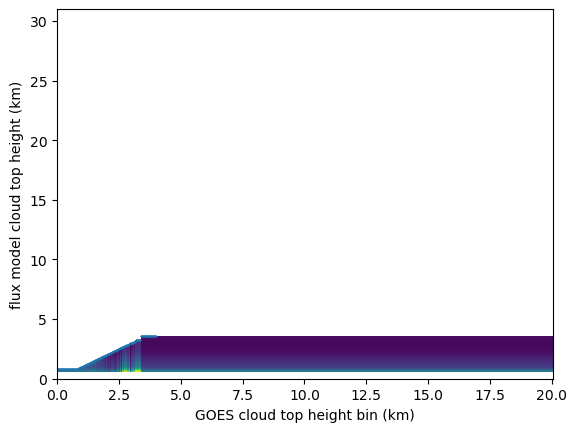

In [ ]:
size(zt53[iz]) # 617
size(cthbins[ii]) # 617, aligned model and satellite cloud top heights
pcolormesh(cthbins[ii]/1e3, z/1e3, w53[:,iz])

size(zt53) # 600
size(Fcld53) # 3100, 600
size(w53) # 3100, 600
size(cthbins) # 617
size(cth_cloudfrac_byrefl) # 21, 617
size(cth_lowcloudfrac_byrefl) # 21, 617

In [106]:
# compute mass flux and cloud moisture flux ensemble
# for each reflectance bin, (ensemble) cloud top height bin, 
# and vertical level.

Fcldm = mask_above_cloudtop(Fcld53, z, zt53)

if !@isdefined M_i # allocates new arrays
    iz, ii = align_cloudtop_grids(zt53, cthbins)
    M_i    = Array{Union{Missing, Float64}}(missing, size(cth_cloudfrac_byrefl,1), size(w53,1), length(ii) ) # [refl, z] cloud-mean w for the aligned bins
    Gcld_i = Array{Union{Missing, Float64}}(missing, size(cth_cloudfrac_byrefl,1), size(w53,1), length(ii) ) # [refl, z] cloud-mean flux for the aligned bins
    M_i_std    = similar(M_i)    # [refl, z] cloud-mean w for the aligned bins
    Gcld_i_std = similar(Gcld_i) # [refl, z] cloud-mean flux for the aligned bins
end

# exclude clouds above 4 km, yet fill array to be size(cth_cloudfrac_byrefl)
# ai = Array{Union{Missing,Float64}}(missing, size(cth_cloudfrac_byrefl))
# ai[eachindex(cth_cloudfrac_lt4km_byrefl)] .= cth_cloudfrac_lt4km_byrefl[:]
ai = cth_lowcloudfrac_byrefl # [refl,ztop] satellite cloud fraction for the aligned bins
aistd = sqrt.( max.(0,cth_lowcloudfrac_var_byrefl) ) # [refl,ztop] satellite cloud fraction for the aligned bins
ensemble_massflux_G_i!(M_i, Gcld_i; ztop=zt53, Fcld=Fcldm, w=w53, ai=ai, cthbins=cthbins)

# compute standard deviation of mass and moisture fluxes
# ensemble_massflux_G_i!(M_i_std, Gcld_i_std; ztop=zt53, Fcld=Fcldm, w=w53, ai=aistd, cthbins=cthbins)

# cloud fraction is already normalized by area of tiles with the given mean reflectance

In [ ]:
size(w53[:,iz]) # 3100, 600
icb

61

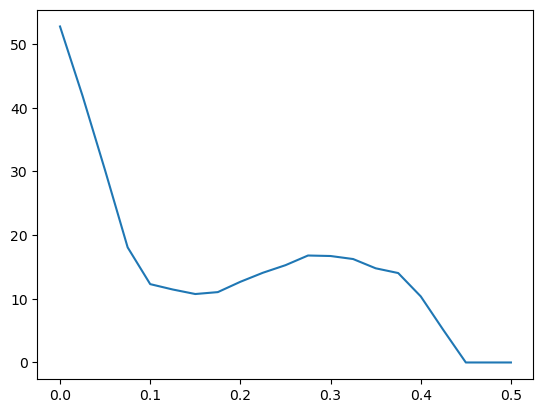

/Users/deszoeks/Projects/ATOMIC/trade-cu-model/src/julia/.CondaPkg/.pixi/envs/default/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/deszoeks/Projects/ATOMIC/trade-cu-model/src/julia/.CondaPkg/.pixi/envs/default/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [ ]:
# calculate the variance of the mass flux M, <M'^2>

Mvar_byrefl = [ calc_M_var(w53[icb,iz],   cth_lowcloudfrac2_byrefl[rb,:,:], cth_lowcloudfrac_byrefl[rb,:]) for rb in eachindex(refl_bin) ]
Gvar_byrefl = [ calc_M_var(Fcldm[icb,iz],  cth_lowcloudfrac2_byrefl[rb,:,:], cth_lowcloudfrac_byrefl[rb,:]) for rb in eachindex(refl_bin) ]
Mstd_byrefl = sqrt.(complex.(Mvar_byrefl))
Gstd_byrefl = sqrt.(complex.(Gvar_byrefl))

close("all")
plot(refl_bin, Mstd_byrefl)
display(gcf())

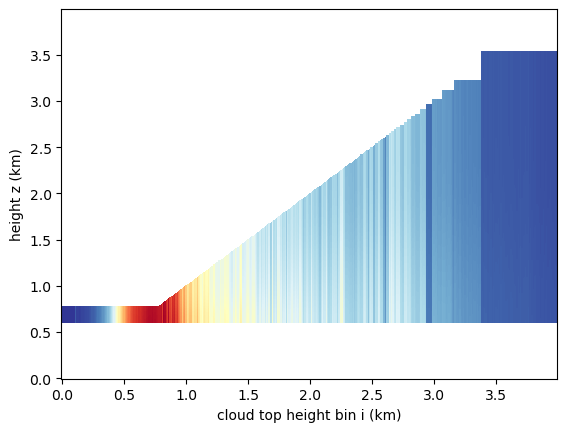

In [ ]:
# look at one reflectance of the ensemble
size(Gcld_i) # r=21, z=3100, i=617

irefl = 5
close("all")
pcolormesh(cthbins[ii[1:ntp]]/1e3, z[1:ntp]/1e3, Gcld_i[irefl,1:ntp,1:ntp], cmap=ColorMap("RdYlBu_r"))
xlabel("cloud top height bin i (km)")
ylabel("height z (km)")
# xlim([0, 4])
# ylim([0, 4])
display(gcf())

In [ ]:
#= not used
Float64.(sum(safe_handle.(Gcld_i_std[:,:,1:ntp].^2), dims=3)[:,:])
=#

21×3100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [ ]:
# sum over ensemble i dimension to get domain-mean mass flux M and Gcld

ntp = 400 # cut off at 4 km
good(x) = !ismissing(x) && !isnan(x) && x!==0
safe_handle(x) = ismissing(x) || isnan(x) ? 0 : x

Gcld_byrefl = Float64.(sum(safe_handle.(Gcld_i[:,:,1:ntp]), dims=3)[:,:]) # [refl, z] domain-mean cloud flux for the aligned bins
M_byrefl    = Float64.(sum(safe_handle.(M_i[:,:,1:ntp]), dims=3)[:,:])    # [refl, z] domain-mean mass flux for the aligned bins

# not right; need double sum of variances
# Gcld_var_byrefl = Float64.(sum(safe_handle.(Gcld_i_std[:,:,1:ntp].^2), dims=3)[:,:]) # [refl, z] domain-mean cloud flux for the aligned bins
# M_var_byrefl    = Float64.(sum(safe_handle.(M_i_std[:,:,1:ntp].^2), dims=3)[:,:])    # [refl, z] domain-mean mass flux for the aligned bins
# Gcld_std_byrefl = sqrt.(Gcld_var_byrefl) ./ sqrt.(sum(good.(Gcld_i_std[:,:,1:ntp]), dims=3)[:,:]) # [refl, z] domain-mean cloud flux for the aligned bins
# M_std_byrefl    = sqrt.(   M_var_byrefl) ./ sqrt.(sum(good.(   M_i_std[:,:,1:ntp]), dims=3)[:,:]) 

21×3100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

21×3100 Matrix{Float64}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
   ⋮                        ⋮            ⋱              ⋮                 
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

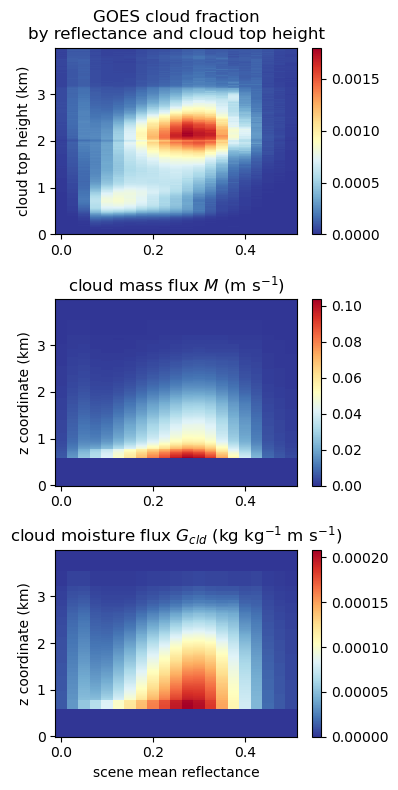

In [64]:
# plot the ensemble cloud fraction, mass flux, moisture flux
ntp = 400

close("all")
figure(figsize=(4, 8))
subplot(3,1,1)
# pcolormesh(refl_bin, cthbins[1:ntp]/1e3, cth_cloudfrac_byrefl'[1:ntp,:], cmap=ColorMap("RdYlBu_r"))
pcolormesh(refl_bin, cthbins[1:ntp]/1e3, cth_lowcloudfrac_byrefl'[1:ntp,:], cmap=ColorMap("RdYlBu_r"))
colorbar()
ylabel("cloud top height (km)")
title("GOES cloud fraction\nby reflectance and cloud top height")

subplot(3,1,2)
pcolormesh(refl_bin, z[1:ntp]/1e3, pd(M_byrefl)[1:ntp,:], cmap=ColorMap("RdYlBu_r"))
colorbar()
title("cloud mass flux \$M\$ (m s\$^{-1}\$)")
ylabel("z coordinate (km)")

subplot(3,1,3)
pcolormesh(refl_bin, z[1:ntp]/1e3, pd(Gcld_byrefl)[1:ntp,:], cmap=ColorMap("RdYlBu_r"))
colorbar()
title("cloud moisture flux \$G_{cld}\$ (kg kg\$^{-1}\$ m s\$^{-1}\$)")
ylabel("z coordinate (km)")
xlabel("scene mean reflectance")

tight_layout()
display(gcf())


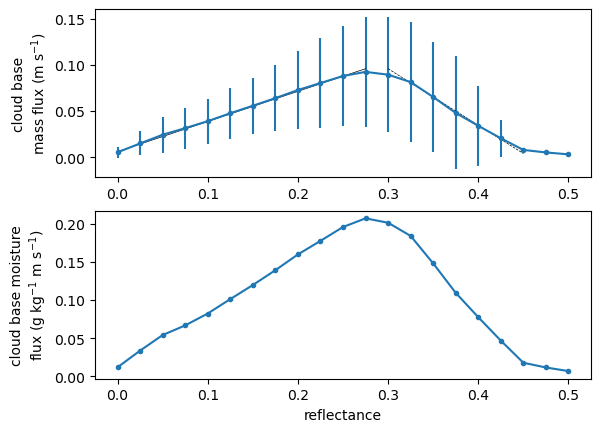

"Clouds over 4 km have been excluded."

In [90]:
close("all")
subplot(2,1,1)
# plot(refl_bin, M_byrefl[:,70], marker=".")
errorbar(refl_bin, M_byrefl[:,70], yerr=M_std_byrefl[:,70], marker=".")
plot([0.0,0.275], [0.006, 0.096], "k", linewidth=0.5,label="0.36 m/s / reflectance")
# rising slope is 0.33 / unit reflectance
plot([0.3,0.45], [0.096, 0.004], "k--", linewidth=0.5,label="0.36 m/s / reflectance")
ylabel("cloud base\nmass flux (m s\$^{-1}\$)")

subplot(2,1,2)
plot(refl_bin, 1e3*Gcld_byrefl[:,70], marker=".")
ylabel("cloud base moisture\nflux (g kg\$^{-1}\$ m s\$^{-1}\$)")
xlabel("reflectance")
display(gcf())
"Clouds over 4 km have been excluded."

Cloud mass and moisture flux in the shallow cumulus increase linearly over r=0.025 to r=0.2. 
(No clouds low enough are modeled to match scenes with reflectance < 0.05.)
This is a rate of 0.34 m/s per unit reflectance.
340 mm/s per unit = 3.4 mm/s/ %
The increase in shallow cumulus mass flux continues nearly at this rate to its maximum 0.089 m/s at r=0.275.

Beyond r=3, mass flux requred by the shallow cumulus cloud fraction decreases at 0.48 m/s per unit reflectance.

In [59]:
maximum(M_byrefl[:,70])

0.08886509315419708